# RNN practice
- make simple RNN

first make a sample dataset

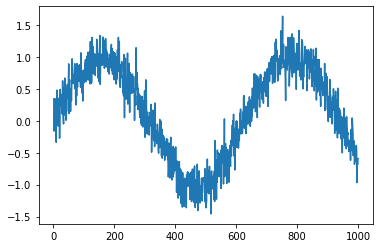

In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

T = 1000
time = torch.arange(1, T+1, dtype=torch.float32)
y = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
# xs = [x for x in range(1,T+1)]


plt.plot(time, y)

In [3]:
# make chunks of data
tau = 4
features = torch.zeros((T-tau, tau))
for i in range(tau):
    features[:,i] = y[i: T - tau + i]
labels = y[tau:].reshape((-1,1))

batch_size, n_train = 16, 600

In [22]:
class MyDataset(Dataset):
    '''
    Dataset class for my private dataset
    '''
    def __init__(self, data, y):
        self.y = y
        self.xs = data
        self.transform = None
        self.target_transform = None
        
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        data = self.xs
        y = self.y
        return data, y

train_dataset = MyDataset(features[:n_train], labels[:n_train])

In [23]:
features.shape
labels.shape

torch.Size([996, 1])

In [24]:
train_iter = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [25]:
def init_weight(m):
    '''
    initializes weight with xavier uniform distribution
    '''
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
    
def get_net():
    '''
    function that makes net(NN)
    '''
    net = nn.Sequential(
        nn.Linear(4,10),
        nn.ReLU(),
        nn.Linear(10,1))
    net.apply(init_weight)
    return net

# define loss function
loss = nn.MSELoss(reduction='none')
    

In [30]:
def train(net, train_iter, loss, epochs, lr):
    '''
    functionize a trainer
    '''
    # set an optimizer
    trainer = torch.optim.Adam(net.parameters(), lr)
    
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
            f'loss: {l.sum()/batch_size}')

net = get_net()
train(net, train_iter, loss, 1000, 0.01)

epoch 1, loss: 164.6091766357422
epoch 2, loss: 88.2710189819336
epoch 3, loss: 76.73303985595703
epoch 4, loss: 64.68154907226562
epoch 5, loss: 59.600006103515625
epoch 6, loss: 55.96217346191406
epoch 7, loss: 53.53693389892578
epoch 8, loss: 52.21988296508789
epoch 9, loss: 51.12017059326172
epoch 10, loss: 50.260501861572266
epoch 11, loss: 49.52252960205078
epoch 12, loss: 48.93098831176758
epoch 13, loss: 48.44475555419922
epoch 14, loss: 48.03876495361328
epoch 15, loss: 47.69041442871094
epoch 16, loss: 47.391868591308594
epoch 17, loss: 47.1374626159668
epoch 18, loss: 46.936153411865234
epoch 19, loss: 46.77192306518555
epoch 20, loss: 46.62080383300781
epoch 21, loss: 46.48624801635742
epoch 22, loss: 46.3662109375
epoch 23, loss: 46.26132583618164
epoch 24, loss: 46.170501708984375
epoch 25, loss: 46.090301513671875
epoch 26, loss: 46.019126892089844
epoch 27, loss: 45.95453643798828
epoch 28, loss: 45.89486312866211
epoch 29, loss: 45.84016799926758
epoch 30, loss: 45.790

The loss is not getting any lower

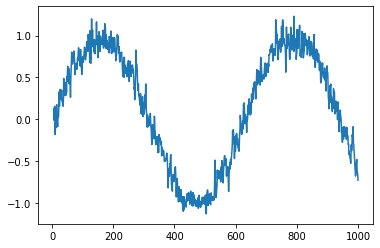

In [66]:
onestep_preds = net(features)
plt.plot(time[4:], onestep_preds.detach().numpy().squeeze())

although the model has some differences, the models still outputs a similar pattern from the $x$